## VAE analysis of two lung cancer sets (top 100 genes)

This notebook can be run locally or on a remote cloud computer by clicking the badge below:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/statisticalbiotechnology/cb2030/master?filepath=nb%2Fvae%2FVAEofCarcinomas100.ipynb) or [![CoLab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statisticalbiotechnology/cb2030/blob/master/nb/vae/VAEofCarcinomas100.ipynb)

Here we training a VAE of two different datasets within the TCGA. We will first merge the two datasets and subsequently try to separate the samples based on their latent variables. This is made in analogue with the notebook on PCA.

First we retrieve our two TCGA lungcancer data from cbioportal.org. One of the sets are from [Lung Adenocarcinomas](https://en.wikipedia.org/wiki/Adenocarcinoma_of_the_lung) and the other is from [Lung Squamous Cell Carcinomas](https://en.wikipedia.org/wiki/Squamous-cell_carcinoma_of_the_lung). We first load our dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ![ ! -f "cb2030/README.md" ] && git clone https://github.com/statisticalbiotechnology/cb2030.git
    my_path = "cb2030/nb/"
else:
    my_path = "../"
sys.path.append(my_path) # Read local modules for tcga access and qvalue calculations

import tcga_read as tcga

luad = tcga.get_expression_data(my_path + "../data/luad.tsv.gz", 'https://cbioportal-datahub.s3.amazonaws.com/luad_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")
lusc = tcga.get_expression_data(my_path + "../data/lusc.tsv.gz", 'https://cbioportal-datahub.s3.amazonaws.com/lusc_tcga_pan_can_atlas_2018.tar.gz',"data_RNA_Seq_v2_expression_median.txt")

We now merge the datasets, and see too that we only include transcripts that are measured in all the carcinomas with an count larger than 0. Further we scale the measurements so that every gene expression value is scaled between 0 and 1, using sk-learns [MinMaxScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). In this variant I also just keep the 100 genes found most differential between the cancer groups.

In [2]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
combined = pd.concat([lusc, luad], axis=1, sort=False)
combined.dropna(axis=0, how='any', inplace=True)
combined = combined.loc[~(combined<=0.0).any(axis=1)]
X=scaler.fit_transform(np.log2(combined).T).T
combined = pd.DataFrame(data=X,index=combined.index,columns=combined.columns)
which_set = [1.0 for _ in lusc.columns]+[ 0.0 for _ in luad.columns]
is_lusc = pd.Series(data=[True for _ in lusc.columns]+[ False for _ in luad.columns], index=combined.columns,name='is_lusc')
#is_lusc = pd.DataFrame(data=[[True for _ in lusc.columns]+[ False for _ in luad.columns]], columns=combined.columns, index=['is_lusc'])


In [3]:
import qvalue
from scipy.stats import ttest_ind

def get_significance_two_groups(row):
    log_fold_change = row[is_lusc].mean() - row[~is_lusc].mean()
    p = ttest_ind(row[is_lusc],row[~is_lusc],equal_var=False)[1]
    return [p,-np.log10(p),log_fold_change]

pvalues = combined.apply(get_significance_two_groups,axis=1,result_type="expand")
pvalues.rename(columns = {list(pvalues)[0]: 'p', list(pvalues)[1]: '-log_p', list(pvalues)[2]: 'log_FC'}, inplace = True)
qvalues = qvalue.qvalues(pvalues)

top100=combined.loc[qvalues.iloc[:100,:].index]


We are setting up an istance of a machine learning framework, [PyTorch](https://en.wikipedia.org/wiki/PyTorch). It will help us fitting the needed neural network.

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.utils.data
from torch.nn import functional as F
from torchvision import datasets, transforms


import numpy as np

from tqdm import tqdm
from torchvision.utils import make_grid

## We use a GPU and hence need cuda, https://en.wikipedia.org/wiki/CUDA
no_cuda = False

## Some arbitrarly selected training parameters
batch_size, lr, epochs, log_interval = 128, 1e-3, 100, 5

## Some parameters governing the architecture.
hidden_dim, latent_dim = 64, 2

use_cuda = not no_cuda and torch.cuda.is_available()

torch.manual_seed(4711)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


When training a network on a GPU, we need a special data loader that can transfer the data to the GPU.

In [5]:
class ExpressionDataset(Dataset):
    def __init__(self, datapoints, labels):
        self.x_dim = datapoints.shape[0]
        self.datapoints = torch.tensor(datapoints.to_numpy().T, dtype=torch.float32)
        print(self.datapoints)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.datapoints[idx],self.labels[idx]

train_dataset = ExpressionDataset(top100,which_set)
#train_dataset = ExpressionDataset(combined,(["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns]))
#test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
x_dim  = train_dataset.x_dim

tensor([[0.7532, 0.7463, 1.0000,  ..., 0.5956, 0.4242, 0.6870],
        [0.7893, 0.8297, 0.7079,  ..., 0.6704, 0.6171, 0.7189],
        [0.7525, 0.7814, 0.7742,  ..., 0.6638, 0.3895, 0.6505],
        ...,
        [0.2260, 0.6189, 0.3602,  ..., 0.0328, 0.1797, 0.6209],
        [0.2009, 0.5181, 0.2496,  ..., 0.2456, 0.3354, 0.1951],
        [0.3931, 0.3455, 0.2908,  ..., 0.2955, 0.3394, 0.3610]])


Now we design the VAE. We use an architecure where 13046 features are first throtteled down to 64 features (fc1) then to 2 features, which we predict both mean and variance for (fc21 and fc22).   

We reparametrize those 2 variables, and then expand them to 64 (fc3) and 13046 (fc4) features.
![](img/nn.svg)


In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim, hidden_dim)       # Input layer of encoder
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Output layer (mean)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Output layer (stdv)
        self.fc3 = nn.Linear(latent_dim, hidden_dim)  # Input layer of decoder
        self.fc4 = nn.Linear(hidden_dim, x_dim)       # Output layer of decoder

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)         # Dividing a logged value by two results in the log of the sqrt of the value 
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        out = torch.sigmoid(self.fc4(h3))
        return out

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


Next, we next select a gradient descent optimizer, [Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam), and select a fuction to optimize, the loss_function, and we define a train and test procedure to use.

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, x_dim), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # Calculating the Kullback–Leibler divergence
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #print(f"BCE={BCE}, KLD={KLD}")
    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if epoch % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
    if epoch % log_interval == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
#        for i, (data, _) in enumerate(train_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
    if epoch % log_interval == 0:
        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


Now we are set to run the procedure for 1000 epochs.

In [8]:
for epoch in range(1, epochs + 1):
    train(epoch)
test(epoch)

Train Epoch: 5 [0/994 (0%)]	Loss: 67.929939
Train Epoch: 5 [128/994 (12%)]	Loss: 67.799461
Train Epoch: 5 [256/994 (25%)]	Loss: 67.954506
Train Epoch: 5 [384/994 (38%)]	Loss: 68.066231
Train Epoch: 5 [512/994 (50%)]	Loss: 67.802010
Train Epoch: 5 [640/994 (62%)]	Loss: 68.115578
Train Epoch: 5 [768/994 (75%)]	Loss: 67.771217
Train Epoch: 5 [686/994 (88%)]	Loss: 67.649962
====> Epoch: 5 Average loss: 67.8932
Train Epoch: 10 [0/994 (0%)]	Loss: 66.021194
Train Epoch: 10 [128/994 (12%)]	Loss: 65.832878
Train Epoch: 10 [256/994 (25%)]	Loss: 65.517410
Train Epoch: 10 [384/994 (38%)]	Loss: 65.725746
Train Epoch: 10 [512/994 (50%)]	Loss: 65.452171
Train Epoch: 10 [640/994 (62%)]	Loss: 65.809822
Train Epoch: 10 [768/994 (75%)]	Loss: 65.830292
Train Epoch: 10 [686/994 (88%)]	Loss: 65.692527
====> Epoch: 10 Average loss: 65.7365
Train Epoch: 15 [0/994 (0%)]	Loss: 65.374794
Train Epoch: 15 [128/994 (12%)]	Loss: 65.016136
Train Epoch: 15 [256/994 (25%)]	Loss: 65.163696
Train Epoch: 15 [384/994 (38%)

We have now trained our VAE. We can first evaluate it for the datapoints we trained it on, and get their embeddings in a vector, $y$.

In [9]:
model.eval()

x_batch, z_batch, std_batch = [], [], []
with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.to(device)
        
        x_hat_, mean_, log_var = model(x)
        x_batch.append(x_hat_.cpu().detach().numpy())
        z_batch.append(mean_.cpu().detach().numpy())
        std_batch.append(torch.exp(log_var*0.5).cpu().detach().numpy())

x_hat = np.concatenate(x_batch, axis=0)
z = np.concatenate(z_batch, axis=0)
std = np.concatenate(std_batch, axis=0)

100%|██████████| 8/8 [00:00<00:00, 95.70it/s]


We can now use the embeddings to describe our data. Much like for the PCA we can use the embeddings to give a dimentionallity reduced description of each cancer's expression profile. 

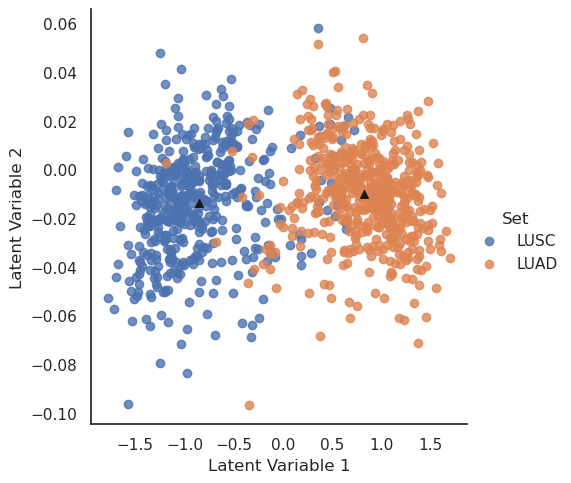

In [10]:
from matplotlib.patches import Ellipse
transformed_patients = pd.DataFrame(data=z,columns=["Latent Variable 1","Latent Variable 2"],index=list(lusc.columns) + list(luad.columns))
transformed_patients["Set"]= (["LUSC" for _ in lusc.columns]+["LUAD" for _ in luad.columns])

sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("white")
#sns.set_context("talk")

lm = sns.lmplot(x="Latent Variable 1",y="Latent Variable 2", hue='Set', data=transformed_patients, fit_reg=False)
#for x, y, (w, h) in zip(transformed_patients["Latent Variable 1"], transformed_patients["Latent Variable 2"], std):
#    lm.axes[0, 0].add_patch(Ellipse((x,y), w, h, fc='#CCCCCC', lw=1, alpha=0.5, zorder=1))
means={}
for name,set_ in transformed_patients.groupby("Set"):
    means[name] = set_.mean(numeric_only=True).to_numpy()
    plt.scatter(means[name][0],means[name][1], marker='^',s=30,c='k')

Here we see a quite good, but not perfect separation of the patients based on two latent variables.

## Using the Decoder for generating example data

Furter, we can use the network to generate "typical" expression profiles. We have marked the means of each sample with black triangles. We will now take these mean values of each patient group and use them as representation of each cancer type, and feed these two values for each patient group to the VAE's decoder.

In [11]:
z_fix = torch.tensor(np.concatenate(([means["LUSC"]],[means["LUAD"]]), axis=0))

z_fix = z_fix.to(device)
x_fix = model.decode(z_fix).cpu().detach().numpy()
predicted = pd.DataFrame(data=x_fix.T, index=top100.index, columns=["LUSC", "LUAD"])

Using these generated profiles we may for instance identify the genes most differential between the generated LUSC and LUAD sample. 

In [12]:
predicted["diff"] = predicted["LUSC"] - predicted["LUAD"]
# predicted.sort_values(by='diff', ascending=False, inplace = True)

The genes pointing in a negative direction for the two components are:

In [13]:
predicted["diff"].idxmin(axis=0)

'RGL3'

In [14]:
predicted["diff"].idxmax(axis=0)

'S1PR5'

Here these two genes seems to be the largest differentiators beteen the genes in LUSC and LUAD. We can also note that as before, the Gene KRT17 seems quite different between the cancer types:

In [15]:
predicted.loc["KRT17"]

LUSC    0.764268
LUAD    0.457494
diff    0.306775
Name: KRT17, dtype: float32

Here I added some illustration of sampling. I sampled 100 samples from the first cancer and 100 from patient 600, and made a plot comparing their distributions.

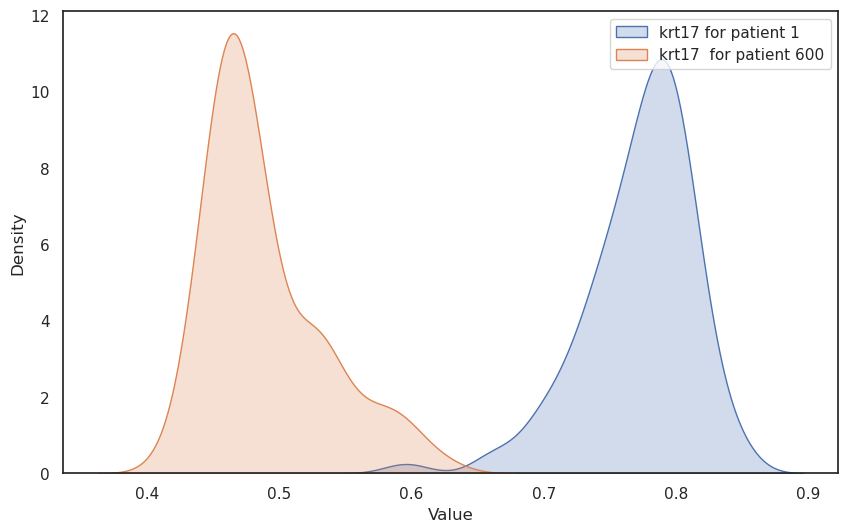

In [16]:
ix = np.argmax(top100.index =="KRT17")
krt17_1 = []
mu, logvar = model.encode(torch.tensor(top100.iloc[:,0].to_numpy(), dtype=torch.float32).view(-1, x_dim).to(device))
for i in range(100):
    z = model.reparameterize(mu, logvar)
    krt17_1.append(model.decode(z).cpu().detach().numpy()[0][ix])
krt17_2 = []
mu, logvar = model.encode(torch.tensor(top100.iloc[:,600].to_numpy(), dtype=torch.float32).view(-1, x_dim).to(device))
for i in range(100):
    z = model.reparameterize(mu, logvar)
    krt17_2.append(model.decode(z).cpu().detach().numpy()[0][ix])
plt.figure(figsize=(10, 6))

# Plotting the KDE for both lists
sns.kdeplot(krt17_1, fill=True, label='krt17 for patient 1')
sns.kdeplot(krt17_2, fill=True, label='krt17  for patient 600')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
